### Exploring Silence/non-Silence Detection for Verse and Chorus Detection in Vocal Cover Versions.

source code for segmentation:
* https://librosa.github.io/librosa/auto_examples/plot_viterbi.html#sphx-glr-auto-examples-plot-viterbi-py

In [8]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa

In [15]:
def metadata_load(path):
    
    lines = []
    with open(path) as fp:
        for cnt, line in enumerate(fp):
            lines.append(line.split('\t'))

    df = pd.DataFrame.from_records(lines)
    df = df.rename(columns={0: 'start', 1: 'end', 2: 'num_label', 3: 'label'})
    df['start'] = pd.to_numeric(df['start'])
    df['end'] = pd.to_numeric(df['end'])
    df['duration'] = df['end'] - df['start']

    labels = [i.strip('\n') for i in df['label'].tolist()]
    
    d = {}
    d['all_metadata'] = df
    d['metadata_start'] = df['start'].tolist()
    d['metadata_end'] = df['end'].tolist()
    d['labels'] = labels
     
    return d

In [16]:
def get_voice_arr(states, times):
    
    vocal_start = []
    vocal_end = []

    for i, val in enumerate(states):

        if i == 0 and states[i] == 1:
            vocal_start.append(times[i])

        if i != (len(states)-1) :
            if states[i] == 1 and states[i+1] == 0:
                vocal_end.append(times[i])
            if states[i] == 0 and states[i+1] == 1:
                vocal_start.append(times[i+1])

    return vocal_start, vocal_end

In [21]:
def segmenter(audio_file, metadata):

    y, sr = librosa.load(audio_file)

    # compute the spectrogram magnitude and phase
    S_full, phase = librosa.magphase(librosa.stft(y))

    # compute rms, normalize
    rms = librosa.feature.rms(y=y)[0]
    times = librosa.frames_to_time(np.arange(len(rms)))
    r_normalized = (rms - 0.02) / np.std(rms)
    p = np.exp(r_normalized) / (1 + np.exp(r_normalized))
    TH = np.mean(p)
    
    # viterbi
    transition = librosa.sequence.transition_loop(2, [0.5, 0.6])
    full_p = np.vstack([1 - p, p])

    states = librosa.sequence.viterbi_discriminative(full_p, transition)
    
    vocal_start, vocal_end = get_voice_arr(states, times)
    
    metadata_start = metadata['metadata_start']
    metadata_end = metadata['metadata_end']
    labels = metadata['labels']
        
    # plot
    plt.figure(figsize=(15, 6))
    plt.plot(times, p, label='P[V=1|x]')
    plt.axhline(TH, color='r', alpha=0.5, label='threshold')
    plt.xlabel('Time')
    plt.axis('tight')
    plt.legend()

    xcoords = list(metadata_start) + list(metadata_end)
    colors = 'r'*len(xcoords)
    for xc,c in zip(xcoords, colors):
        plt.axvline(x=xc, label='line at x = {}'.format(xc), c=c)

    for i in range(0, len(metadata_start)):
        duration = metadata_end[i] - metadata_start[i]
        plt.text(metadata_start[i]+duration/2, 0.9, labels[i], size=13, rotation=90.,
                 ha="center", va="center",
                 bbox=dict(boxstyle="round",
                           ec=(1., 0.5, 0.5),
                           fc=(1., 0.8, 0.8),
                           )
                 )

    plt.tight_layout()

In [22]:
metadata = metadata_load(path='structure_workshop/pop/hero.groundtruth.txt')
metadata['all_metadata'].head()

,start,end,num_label,label,duration
0,0.0,16.0,1,Intro/Outro\n,16.0
1,16.0,32.0,2,Verse\n,16.0
2,32.0,48.0,2,Verse\n,16.0
3,48.0,64.0,4,Chorus\n,16.0
4,64.0,80.0,4,Chorus\n,16.0


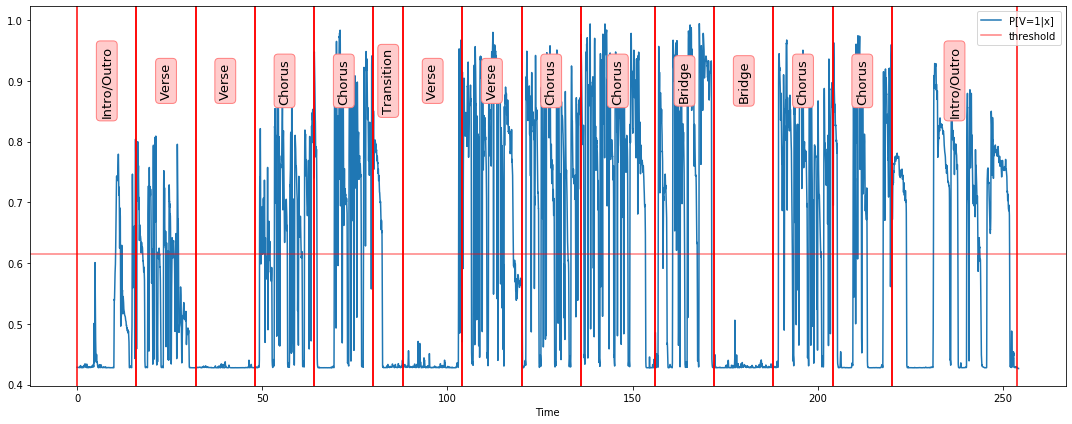

In [23]:
vocal_single = 'structure_workshop/pop/hero_vocal_1.wav'
segmenter(vocal_single, metadata)

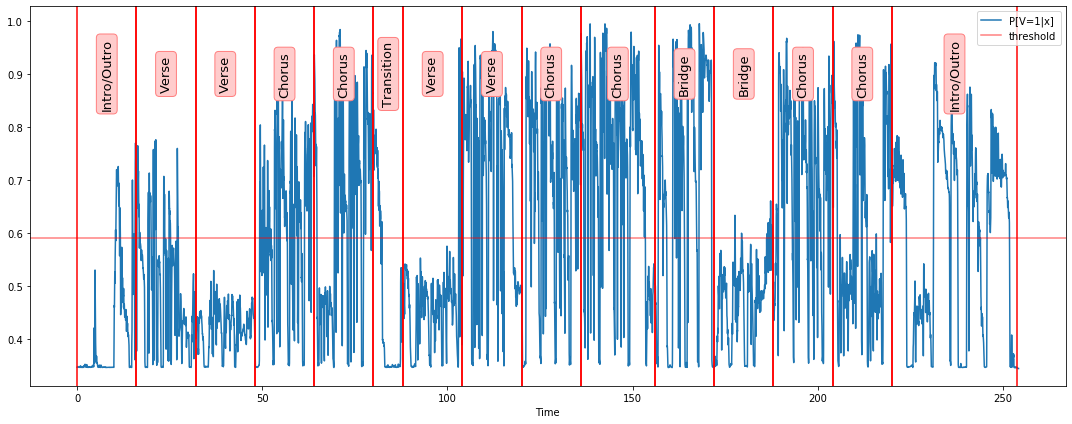

In [24]:
vocals_2 = 'structure_workshop/pop/hero_vocals.wav'
segmenter(vocals_2, metadata)